# Find duplicate candidates


Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

This notebook is part of the EStreams publication and is used to find potential duplicated catchments within the dataset.

* Note that this code enables not only the replicability of the current database but also the extrapolation to new catchment areas. 
* Additionally, the user should download and insert the original raw-data in the folder of the same name prior to run this code. 
* The original third-party data used were not made available in this repository due to redistribution and storage-space reasons.  

## Requirements
**Python:**

* Python>=3.6
* Jupyter
* geopandas=0.10.2
* numpy
* os
* pandas
* shapely
* textdistance
* tqdm
* warnings

Check the Github repository for an environment.yml (for conda environments) or requirements.txt (pip) file.

**Files:**

* data/streamflow/estreams_gauging_stations.csv

**Directory:**

* Clone the GitHub directory locally
* Place any third-data variables in their respective directory.
* ONLY update the "PATH" variable in the section "Configurations", with their relative path to the EStreams directory. 

## References


## Observations
* As this step is rather qualitative, we believe that the users can also adapt the conditons accordinly. 


# Import modules

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import tqdm as tqdm
import os
import warnings
import textdistance
from shapely.geometry import Point

# Configurations

In [2]:
# Only editable variables
# Relative path to your local directory
PATH = "../../.."

# Suppress all warnings
warnings.filterwarnings("ignore")

# Constrains
JARO_THRESHOLD = 0.75
SPATIAL_THRESHOLD = 1000
PROVIDER_THRESHOLD = 0.9

* #### The users should NOT change anything in the code below here.


In [3]:
# Non-editable variables:
PATH_OUTPUT = "results/"

# Set the directory:
os.chdir(PATH)

# Import data
## Streamflow gauges network

In [72]:
network_estreams = pd.read_csv('data/streamflow/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)
network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,area,...,area_calc,area_flag,area_perc,start_date,end_date,num_years,num_months,num_days,num_days_gaps,num_continuous_days
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,4647.9,...,4668.379,0,-0.440608,1996-01-01,2019-12-31,24,288,8766,0.0,8766
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,102.0,...,102.287,0,-0.281373,1958-10-01,2019-12-31,62,735,22372,0.0,22372
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,535.2,...,536.299,0,-0.205344,1985-01-02,2019-12-31,35,420,12782,0.0,12782
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,66.6,...,66.286,0,0.471471,1998-01-02,2019-12-31,22,264,8034,0.0,8034
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,72.2,...,72.448,0,-0.343490,1990-01-01,2019-12-31,30,360,10957,0.0,10957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,321.0,...,325.370,0,-1.361371,1978-01-01,1987-12-31,10,120,3652,0.0,3652
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,49.7,...,47.594,0,4.237425,1978-01-01,1987-12-31,10,120,3652,0.0,3652
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,261.0,...,244.731,1,6.233333,1978-01-01,1987-12-31,10,120,3652,0.0,3652


# Processing

In [77]:
# If we want to clip the data to be used:
df = network_estreams.iloc[:, :]

# Create a GeoDataFrame from DataFrame with WGS 84 coordinates
geometry = [Point(lon, lat) for lon, lat in zip(network_estreams['lon'], network_estreams['lat'])]
gdf_wgs84 = gpd.GeoDataFrame(network_estreams, geometry=geometry, crs='EPSG:4326')

# Reproject the GeoDataFrame to ETRS89 LAEA (EPSG:3035)
gdf_etrs89 = gdf_wgs84.to_crs(epsg=3035)

df = gdf_etrs89.loc[df.index, :]

In [78]:
# Create a dictionary to store distances
distances = {}

# Calculate Jaro-Winkler distance for each unique pair of 'gauge_name'
for i, row1 in tqdm.tqdm(df.iterrows()):
    for j, row2 in gdf_etrs89.iterrows():
        # Skip self-comparisons
        if i != j:
            # Calculate gauge name distance
            try:
                gauge_distance = textdistance.jaro_winkler(row1['gauge_name'].lower(), row2['gauge_name'].lower())
            except: 
                gauge_distance = np.nan
                
            # Calculate river distance
            try:
                river_distance = textdistance.jaro_winkler(row1['river'].lower(), row2['river'].lower())
            except: 
                river_distance = np.nan
                

            provider_distance = row1['gauge_provider'].lower() == row2['gauge_provider'].lower()          
        
            # Calculate distance between points
            point1 = row1['geometry']
            point2 = row2['geometry']
            point_distance = point1.distance(point2)
            
            # gauges and river distance normalized:
            #dist_norm = (gauge_distance + river_distance)/2
            
            # Store distances along with first and second gauge indices only if gauge_distance > 0.9
            if (gauge_distance > JARO_THRESHOLD) & (river_distance > JARO_THRESHOLD) & (point_distance < SPATIAL_THRESHOLD) & (provider_distance == False):
                distances[(row1['gauge_name'], row2['gauge_name'])] = {'gauge_first_index': i, 
                                                                        'gauge_second_index': j,
                                                                        'gauge_distance': gauge_distance, 
                                                                        'river_distance': river_distance,
                                                                        'point_distance': point_distance,
                                                                        'provider_distance': provider_distance}
# Convert dictionary to DataFrame for visualization
dist_df = pd.DataFrame.from_dict(distances, orient='index')
dist_df.index.names = ['gauge_name1', 'gauge_name2']
dist_df.reset_index(inplace = True)
dist_df

15047it [4:19:27,  1.03s/it]


,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
0,Bangs,Bangs,CH000197,AT000001,1.000000,1.000000,554.431769,False
1,Schruns (Vonbunweg),Schruns_(Vonbunweg),AT000002,CH000221,0.978947,1.000000,281.435851,False
2,Loruens-Aeule,Loruens-Aeule,CH000215,AT000003,1.000000,1.000000,356.336721,False
3,Kloesterle (OEBB),Kloesterle_(OEBB),AT000004,CH000227,0.976471,1.000000,179.092492,False
4,Buers (Bruecke L82),Buers_(Bruecke_L82),AT000005,CH000214,0.957895,1.000000,219.861947,False
...,...,...,...,...,...,...,...,...
128,Calamazza,CALAMAZZA,ITTO0386,ITLI0307,1.000000,1.000000,51.945958,False
129,Calamazza ARPAL,CALAMAZZA,ITTO0389,ITLI0307,0.920000,1.000000,423.716013,False
130,CHAŁUPKI,Chalupki,PL000001,CZ000344,0.941667,0.900000,3.567275,False
131,BRANICE,Branice,PL000030,CZ000311,1.000000,0.804848,17.213067,False


In [79]:
len(dist_df.gauge_first_index.unique())

132

In [80]:
dist_df.head(50)

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
0,Bangs,Bangs,CH000197,AT000001,1.000000,1.000000,554.431769,False
1,Schruns (Vonbunweg),Schruns_(Vonbunweg),AT000002,CH000221,0.978947,1.000000,281.435851,False
2,Loruens-Aeule,Loruens-Aeule,CH000215,AT000003,1.000000,1.000000,356.336721,False
3,Kloesterle (OEBB),Kloesterle_(OEBB),AT000004,CH000227,0.976471,1.000000,179.092492,False
4,Buers (Bruecke L82),Buers_(Bruecke_L82),AT000005,CH000214,0.957895,1.000000,219.861947,False
5,Garsella,Garsella,CH000218,AT000006,1.000000,1.000000,484.251040,False
6,Beschling,Beschling,CH000205,AT000007,1.000000,1.000000,93.404431,False
7,Amerluegen,Amerluegen,CH000201,AT000008,1.000000,1.000000,548.837746,False
8,Gisingen,Gisingen,CH000199,AT000009,1.000000,1.000000,93.904040,False
9,Laterns,Laterns,CH000209,AT000010,1.000000,1.000000,351.603532,False


In [81]:
most_common_name = dist_df['gauge_first_index'].value_counts().idxmax()

print("The most common name in the column is:", most_common_name)

The most common name in the column is: ITLI0307


In [82]:
dist_df[dist_df.gauge_first_index == "ITLI0307"]

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
126,CALAMAZZA,Calamazza,ITLI0307,ITTO0386,1.00,1.0,51.945958,False
127,CALAMAZZA,Calamazza ARPAL,ITLI0307,ITTO0389,0.92,1.0,423.716013,False


<Axes: xlabel='gauge_first_index'>

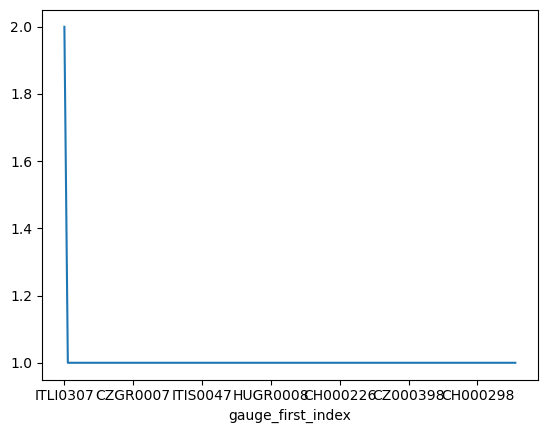

In [83]:
dist_df['gauge_first_index'].value_counts().plot()

In [84]:
# Here we add the list of duplicated suspects:

In [124]:
network_estreams["duplicated_suspect"] = ""

In [128]:
# First column:
for gauge in tqdm.tqdm(dist_df.gauge_first_index):
    
    duplicated_list = str(dist_df.gauge_second_index[dist_df.gauge_first_index == gauge].tolist()).replace("[", "")
    duplicated_list = duplicated_list.replace("]", "")
    duplicated_list = duplicated_list.replace("'", "")
    network_estreams.loc[gauge, "duplicated_suspect"] = duplicated_list
    network_estreams.loc[gauge, "duplicated_suspect"] = network_estreams.loc[gauge, "duplicated_suspect"]

100%|███████████████████████████████████████| 133/133 [00:00<00:00, 7183.69it/s]


In [129]:
# Second column:
for gauge in tqdm.tqdm(dist_df.gauge_second_index):
    
    duplicated_list = str(dist_df.gauge_first_index[dist_df.gauge_second_index == gauge].tolist()).replace("[", "")
    duplicated_list = duplicated_list.replace("]", "")
    duplicated_list = duplicated_list.replace("'", "")
    network_estreams.loc[gauge, "duplicated_suspect"] = duplicated_list
    network_estreams.loc[gauge, "duplicated_suspect"] = network_estreams.loc[gauge, "duplicated_suspect"]

100%|███████████████████████████████████████| 133/133 [00:00<00:00, 7213.79it/s]


In [130]:
network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,area,...,area_flag,area_perc,start_date,end_date,num_years,num_months,num_days,num_days_gaps,num_continuous_days,duplicated_suspect
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,4647.9,...,0,-0.440608,1996-01-01,2019-12-31,24,288,8766,0.0,8766,CH000197
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,102.0,...,0,-0.281373,1958-10-01,2019-12-31,62,735,22372,0.0,22372,CH000221
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,535.2,...,0,-0.205344,1985-01-02,2019-12-31,35,420,12782,0.0,12782,CH000215
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,66.6,...,0,0.471471,1998-01-02,2019-12-31,22,264,8034,0.0,8034,CH000227
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,72.2,...,0,-0.343490,1990-01-01,2019-12-31,30,360,10957,0.0,10957,CH000214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,321.0,...,0,-1.361371,1978-01-01,1987-12-31,10,120,3652,0.0,3652,
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,49.7,...,0,4.237425,1978-01-01,1987-12-31,10,120,3652,0.0,3652,
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,261.0,...,1,6.233333,1978-01-01,1987-12-31,10,120,3652,0.0,3652,


In [131]:
network_estreams.loc["ITLI0307", :]

gauge_id                             CALAM
gauge_name                       CALAMAZZA
gauge_country                           IT
gauge_provider          IT_LIG_CONTACTFORM
river                                MAGRA
lon_snap                           9.95015
lat_snap                          44.19802
lon                                9.95015
lat                               44.19802
area                                 939.0
elevation                               45
area_calc                          938.563
area_flag                                0
area_perc                         0.046539
start_date             1950-01-01 00:00:00
end_date               2022-12-31 00:00:00
num_years                               43
num_months                             515
num_days                             15585
num_days_gaps                      11078.0
num_continuous_days                  10227
duplicated_suspect      ITTO0386, ITTO0389
Name: ITLI0307, dtype: object

In [132]:
# Save the data:
network_estreams.to_csv("results/extras/estreams_gauging_stations_duplicates.csv", encoding='utf-8')

# End